In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset
import torchvision
import matplotlib.patches as patches
import torchvision.transforms as transforms

import os
import time
import torch
import sys
import argparse
sys.path.insert(0, '../../shared_code')
# from network import *
from model_loader_func import * 
from dataloader_func import resize_image, rescale_image_range,int_to_float,rgb_to_gray, patch_generator, single_image_loader,load_dataset,prep_dataset
from noise import add_noise_torch
from quality_metrics_func import *
from linear_approx import *
from inverse_tasks_func import synthesis
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im,plot_matching_patches
from algorithm_inv_prob import * 
from trainer import make_loader
%matplotlib inline

In [2]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.5.0+cu124


device(type='cuda')

# Load Denoisers

In [157]:
denoisers = {}


root_path = '/mnt/home/zkadkhodaie/ceph/22_representation_in_UNet_denoiser/denoisers/'

paths = { 
         # 'mixture-color':       'UNet_flex/texture_EPS_color/0to255_RF_84x84_set_size_237580_color_80x80/', 
         # 'mixture-color-BF-BN': 'UNet_flex/texture_EPS_color/0to300_RF_84x84_set_size_237580_color_BF_BN_80x80/', 
    
         # 'mixture-color-RF112':       'UNet_flex/texture_EPS_color/0to300_RF_112x112_set_size_237580_color_80x80/',
         # 'mixture-color-BF-BN-RF112': 'UNet_flex/texture_EPS_color/0to300_RF_112x112_set_size_237580_color_BF_BN_80x80/', 
         # 'mixture-color-RF112-dilation': '/UNet_flex/texture_EPS_color/0to300_RF_112x112_set_size_237580_color_dilation_80x80/', 
    
        'mixture-color-no-skip-deep-enc':       '/UNet_flex/texture_EPS_color/0to255_RF_84x84_set_size_237580_color_no_skip_deep_enc_80x80/' , 
        # 'mixture-color-no-skip-deep-enc-BF-BN': '/UNet_flex/texture_EPS_color/0to255_RF_84x84_set_size_237580_color_no_skip_deep_dec_BF_BN_80x80/' ,     
        
        'mixture-color-no-skip-deep-sig3-sqrt-inv':       '/UNet_flex/texture_EPS_color/1to765_RF_84x84_set_size_237580_color_no_skip_deep_dec_80x80/' , 
        'mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs':       '/UNet_flex/texture_EPS_color/1to765_RF_84x84_set_size_237580_color_no_skip_deep_dec_80x80_more_epochs/' ,     
         'mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1': '/UNet_flex/texture_EPS_color/1to765_RF_84x84_set_size_237580_color_no_skip_deep_dec_80x80_fine_tuned/',
        'mixture-color-no-skip-deep-sig3-noiseRangeDrop':   '/UNet_flex/texture_EPS_color/1to765_RF_84x84_set_size_237580_color_no_skip_deep_dec_noise_range_drop_80x80/' , 

        'mixture-color-no-skip-deep-sig3-inv':       '/UNet_flex/texture_EPS_color/1to765_RF_84x84_set_size_237580_color_no_skip_deep_80x80/' , 
        'mixture-color-no-skip-deep-sig3-finetunedSig1':    '/UNet_flex/texture_EPS_color/1to765_RF_84x84_set_size_237580_color_no_skip_deep_80x80_fine_tuned/' , 
    
        'mixture-color-no-skip-deep-sig3-uniform-weighted' :'/UNet_flex/texture_EPS_color/1to765_RF_84x84_set_size_237580_color_no_skip_deep_dec_weightedLoss_80x80/',
        # 'mixture-color-no-skip-deep-BF_BN_inv':  '/UNet_flex/texture_EPS_color/1to255_RF_84x84_set_size_237580_color_no_skip_deep_dec_BF_BN_inv_80x80/',


            }

# paths = { 'mixture-gray-2223444': 'UNet_flex/texture_EPS/0to255_RF_84x84_set_size_233660/' , 
#           'mixture-gray-3333333': 'UNet_flex/texture_EPS/0to255_RF_98x98_set_size_233660_arch3333333_80x80//',
#           'mixture-gray-4443222': 'UNet_flex/texture_EPS/0to255_RF_112x112_set_size_233660_arch4443222_80x80/',
#           'mixture-gray-4442444': 'UNet_flex/texture_EPS/0to255_RF_96x96_set_size_233660_arch4442444_80x80/',
#           'mixture-gray-2223444-256ch': 'UNet_flex/texture_EPS/0to255_RF_84x84_set_size_233660_mid_ch_256_80x80/',

# }

groups = paths.keys()

for group in groups: 
    path = root_path + paths[group]

    print('loading group ' , group )
    denoisers[group] = load_learned_model(path, print_args=True)
    start_time_total = time.time()        
    print("--- %s seconds ---" % (round(time.time() - start_time_total)))
     
    

loading group  mixture-color-no-skip-deep-enc
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 237580
imagenet_subset_ids None
data_name texture_EPS_color
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/texture_EPS_color/0to255_RF_84x84_set_size_237580_color_no_skip_deep_enc_80x80
optional_dir_label color_no_skip_deep_enc
device cuda
debug False
kernel_size 3
padding 1
skip False
num_channels 3
bias True
RF 84
coarse True
self_cond False
num_kernels [64, 128, 256, 512]
num_blocks 3
num_enc_conv [2, 2, 2]
num_mid_conv 3
num_dec_conv [5, 6, 7]
NormType LayerNorm
inter_skip True
dilations None
data_path /mnt/home/zkadkhodaie/ceph/datasets/texture_EPS
******************************************************
number of parameters is  1

In [50]:
denoisers.keys()

dict_keys(['mixture-color-no-skip-deep-enc', 'mixture-color-no-skip-deep-sig3-inv', 'mixture-color-no-skip-deep-sig3-sqrt-inv', 'mixture-color-no-skip-deep-sig3-inv-noiseRangeDrop', 'mixture-color-no-skip-deep-sig3-finetunedSig1', 'mixture-color-no-skip-deep-BF_BN_inv_80x80'])

# load data

In [5]:
### color images
# ### for 80x80 patches
data = torch.load(  '/mnt/home/zkadkhodaie/ceph/datasets/texture_EPS/patched_1024x1024_to_80x80_all_sets_color.pt',weights_only=True)
n_patches = int(1024/80)**2 # 144

num_classes = int(data.shape[0]/n_patches) # for 80x80: 882 + 786 #for 128x128:786

##### list of tensors. Each tensor contains images from same class 
train_sets = []
test_sets = []


for d in range(num_classes): 
    train_sets.append(data[n_patches * d: (n_patches * (d+1)) -4 ])
    test_sets.append(data[(n_patches * (d+1)) -4 : (n_patches * (d+1)) ] ) # in each image, leave the last 4 patches for test set       




In [6]:
print('number of images in each class:', train_sets[0].shape)
K = train_sets[0].shape[2]
n_channels = train_sets[0].shape[1]
print(len(train_sets))

number of images in each class: torch.Size([140, 3, 80, 80])
1697


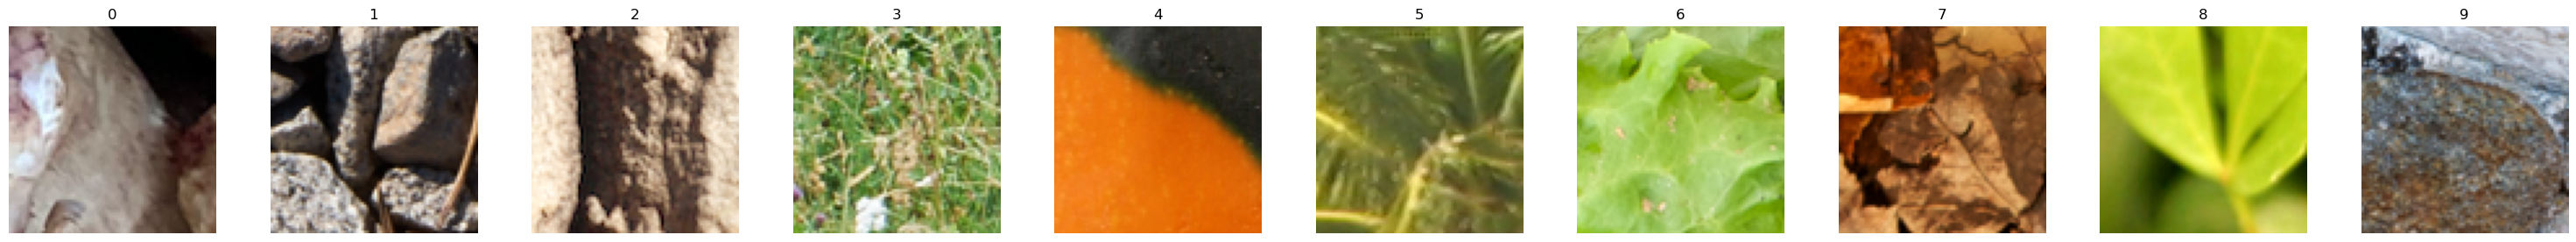

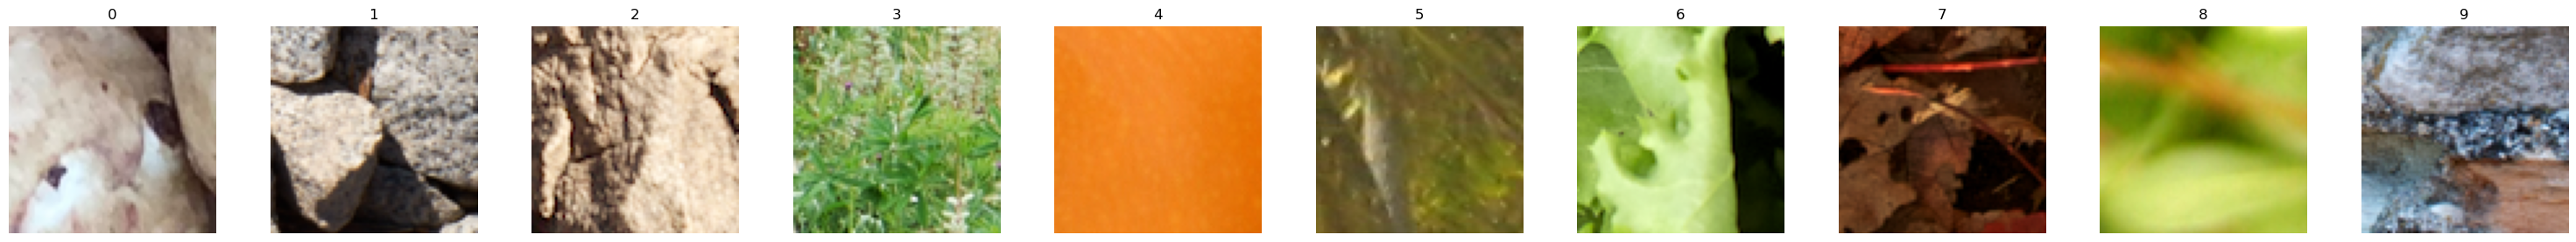

total number of train images: 237580


In [7]:
## shuffle train and test images and put them in one tensor 
loader, loader_cond = make_loader(dataset=train_sets, batch_size=512, dataset_cond=train_sets, self_cond =False)    
train ={}
train['inp']  = loader.dataset
train['cond'] = loader_cond.dataset
show_im_set(train['inp'][0:10], n_columns=10)
show_im_set(train['cond'][0:10], n_columns=10)
print('total number of train images:',train['inp'].shape[0])


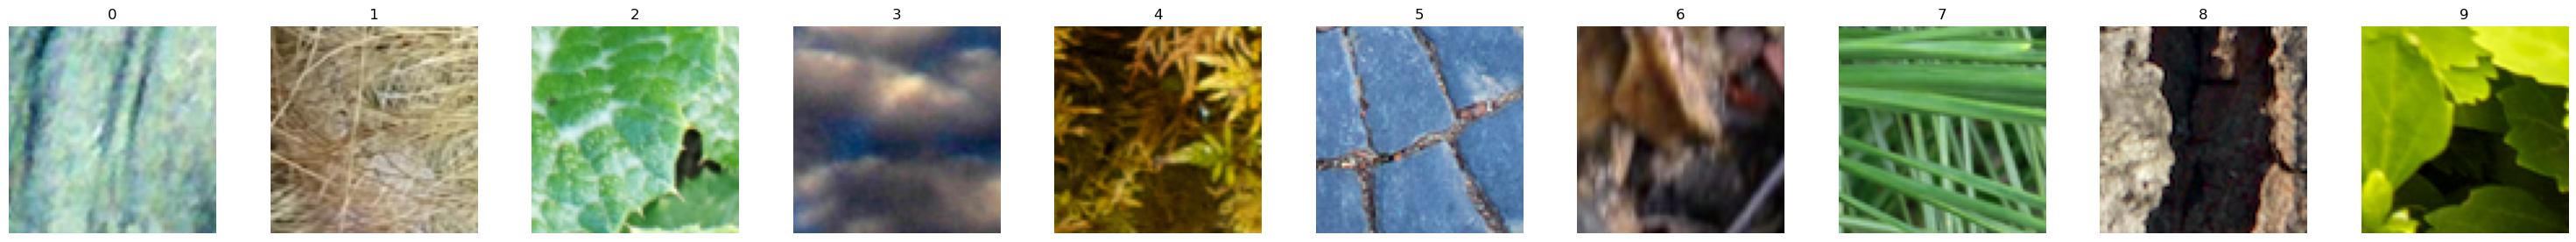

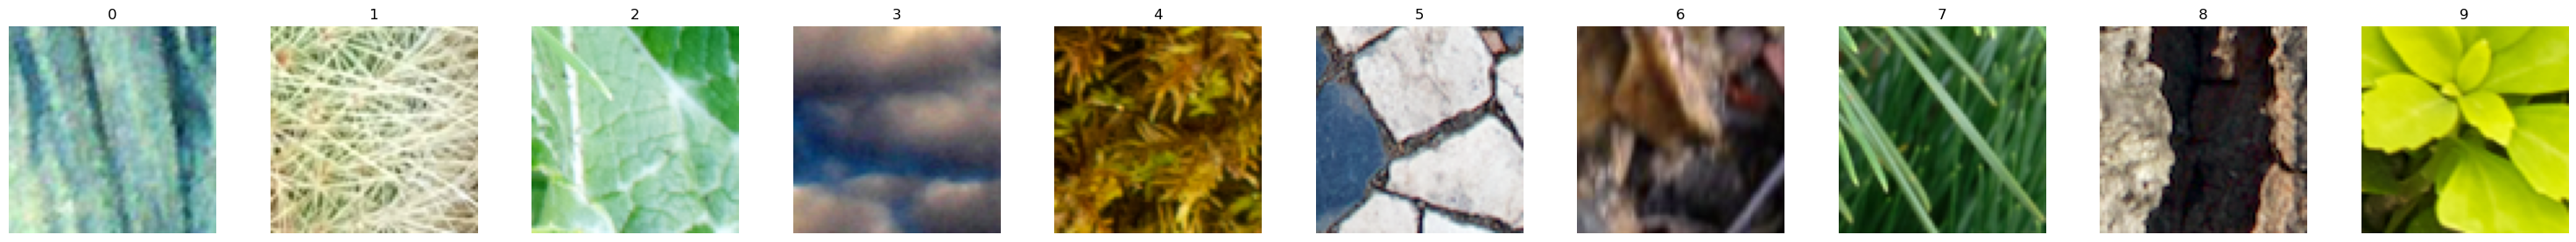

total number of test images: 1024


In [8]:
loader, loader_cond = make_loader(dataset=test_sets, batch_size=256, dataset_cond=test_sets, self_cond =False)        
test ={}
test['inp']  = loader.dataset[0:1024]
test['cond'] = loader_cond.dataset[0:1024]
show_im_set(test['inp'][0:10], n_columns=10)
show_im_set(test['cond'][0:10], n_columns=10)
print('total number of test images:',test['inp'].shape[0])

tensor(0.4199)


80

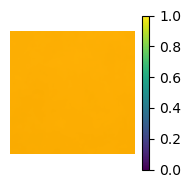

In [9]:
dist_mean = train['inp'].mean(0)
plot_single_im(dist_mean, colorbar=True)
print(dist_mean.mean())
K = dist_mean.shape[2]
K

# denoising performance

In [158]:
## compute psnr 
sig_range = torch.logspace(.01,np.log10(3 * 255),15)

# psnr_test = {}
# psnr_train = {}
for group in  groups: 

    ## train 
    print(group)
    if 'gray' in group.split('-'): 
        loader = DataLoader(dataset=train['inp'][0:512].mean(dim =1, keepdim=True), batch_size=512, shuffle=False)
    else: 
        loader = DataLoader(dataset=train['inp'][0:512], batch_size=512, shuffle=False)
        
    if 'mixture' in group.split('-'): 
        loader_cond = None
    else:
        if 'gray' in group.split('-'):         
            loader_cond = DataLoader(dataset=train['cond'][0:512].mean(dim =1, keepdim=True), batch_size=512, shuffle=False)
        else: 
            loader_cond = DataLoader(dataset=train['cond'][0:512], batch_size=512, shuffle=False)            
    try:
        if 'skip' in group.split('-'):
            skip = False
        else: 
            skip = True
        psnr_train[group] = calc_psnr(denoisers[group],loader,sig_range , device,loader_cond = loader_cond, skip = skip)
        
    except KeyError: 
        pass

    ## test 
    if 'gray' in group.split('-'):     
        loader = DataLoader(dataset=test['inp'][0:512].mean(dim =1, keepdim=True), batch_size=512, shuffle=False)
    else: 
        loader = DataLoader(dataset=test['inp'][0:512], batch_size=512, shuffle=False)
        
    if 'mixture' in group.split('-') : 
        loader_cond = None
    else:        
        if 'gray' in group.split('-'):             
            loader_cond = DataLoader(dataset=test['cond'][0:512].mean(dim =1, keepdim=True), batch_size=512, shuffle=False)
        else: 
            loader_cond = DataLoader(dataset=test['cond'][0:512], batch_size=512, shuffle=False)
            
    try: 
        if 'skip' in group.split('-'):
            skip = False
        else: 
            skip = True     
            
        psnr_test[group] = calc_psnr(denoisers[group],loader,sig_range, device, loader_cond=loader_cond, skip = skip)
      
    except KeyError: 
        pass


mixture-color-no-skip-deep-enc
mixture-color-no-skip-deep-sig3-sqrt-inv
mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs
mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1
mixture-color-no-skip-deep-sig3-noiseRangeDrop
mixture-color-no-skip-deep-sig3-inv
mixture-color-no-skip-deep-sig3-finetunedSig1
mixture-color-no-skip-deep-sig3-uniform-weighted


mixture-color-RF112-dilation
mixture-color-no-skip-deep-enc
mixture-color-no-skip-deep-enc-BF-BN


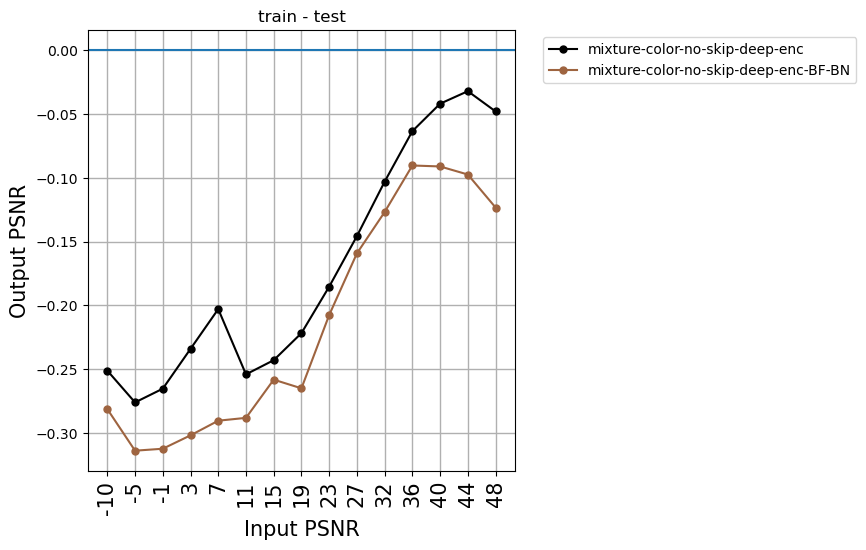

In [35]:
## plot 
f , axs = plt.subplots(1,1, figsize=(5,5), sharex = True, sharey=True)
plt.tight_layout()
print(group)
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[group].keys()]


for group in ['mixture-color-no-skip-deep-enc', 'mixture-color-no-skip-deep-enc-BF-BN' ]: 
    print(group)
    if 'color' in group.split('-'):
        axs.plot(x_axis, [psnr_train[group][key] - psnr_test[group][key] for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
axs.set_title('train - test')

axs.set_xticks(x_axis);
axs.grid(  linewidth=1);
axs.set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
# y_axis = np.linspace(10,60,5) 
# axs.set_yticks(y_axis);

# axs.set_yticklabels(np.round(y_axis).astype(int) , fontsize=15);    

colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(i) for i in np.linspace(0, 1,  3)]
for k,j in enumerate(axs.lines):
    j.set_color(plot_colors[k])
axs.axhline(0)
    
axs.legend(    loc='upper left',    bbox_to_anchor=(1.05, 1),    # (x, y) anchor relative to the axes 
          )      
axs.set_xlabel('Input PSNR', fontsize = 15);
axs.set_ylabel('Output PSNR', fontsize = 15);

mixture-color-no-skip-deep-sig3-uniform-weighted
mixture-color-no-skip-deep-enc
mixture-color-no-skip-deep-sig3-sqrt-inv
mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs
mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1
mixture-color-no-skip-deep-sig3-noiseRangeDrop
mixture-color-no-skip-deep-sig3-inv
mixture-color-no-skip-deep-sig3-finetunedSig1
mixture-color-no-skip-deep-sig3-uniform-weighted


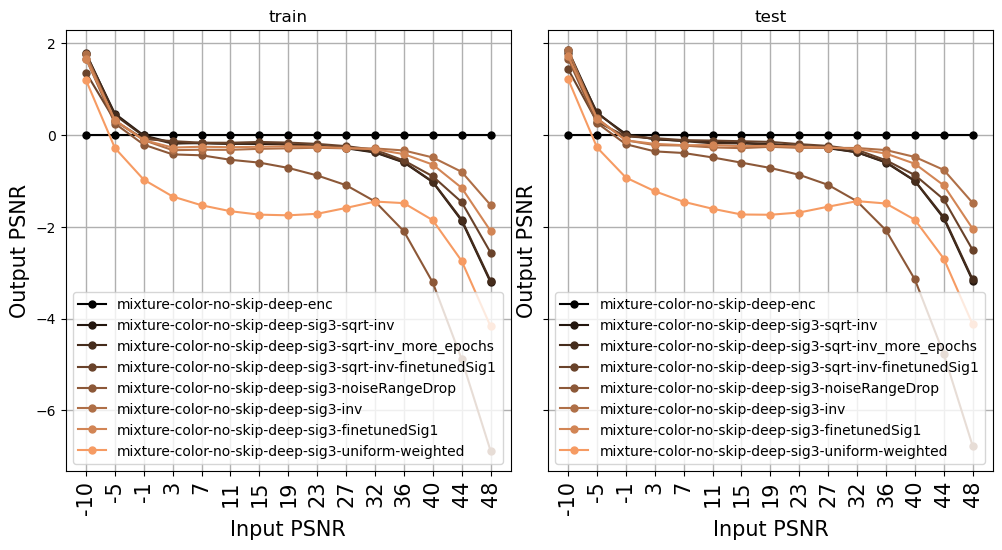

In [159]:
## plot 
f , axs = plt.subplots(1,2, figsize=(10,5), sharex = True, sharey=True)
plt.tight_layout()
print(group)
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[group].keys()]


for group in groups:
    print(group)
    if 'color' in group.split('-'):
        axs[1].plot(x_axis, [psnr_test[group][key] - psnr_test['mixture-color-no-skip-deep-enc'][key] for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
        axs[0].plot(x_axis, [psnr_train[group][key] - psnr_train['mixture-color-no-skip-deep-enc'][key] for key in psnr_train[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
axs[0].set_title('train')
axs[1].set_title('test')

for i in range(2):
    axs[i].set_xticks(x_axis);
    axs[i].grid(  linewidth=1);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    # y_axis = np.linspace(10,60,5) 
    # axs.set_yticks(y_axis);
    
    # axs.set_yticklabels(np.round(y_axis).astype(int) , fontsize=15);    
    
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,  len(psnr_test.keys()))]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
    axs[i].legend()      
    axs[i].set_xlabel('Input PSNR', fontsize = 15);
    axs[i].set_ylabel('Output PSNR', fontsize = 15);


In [149]:
groups

dict_keys(['mixture-color-no-skip-deep-enc', 'mixture-color-no-skip-deep-sig3-sqrt-inv', 'mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs', 'mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1', 'mixture-color-no-skip-deep-sig3-noiseRangeDrop', 'mixture-color-no-skip-deep-sig3-inv', 'mixture-color-no-skip-deep-sig3-finetunedSig1', 'mixture-color-no-skip-deep-sig3-uniform-weighted'])

mixture-color-no-skip-deep-sig3-inv
mixture-color-no-skip-deep-sig3-finetunedSig1


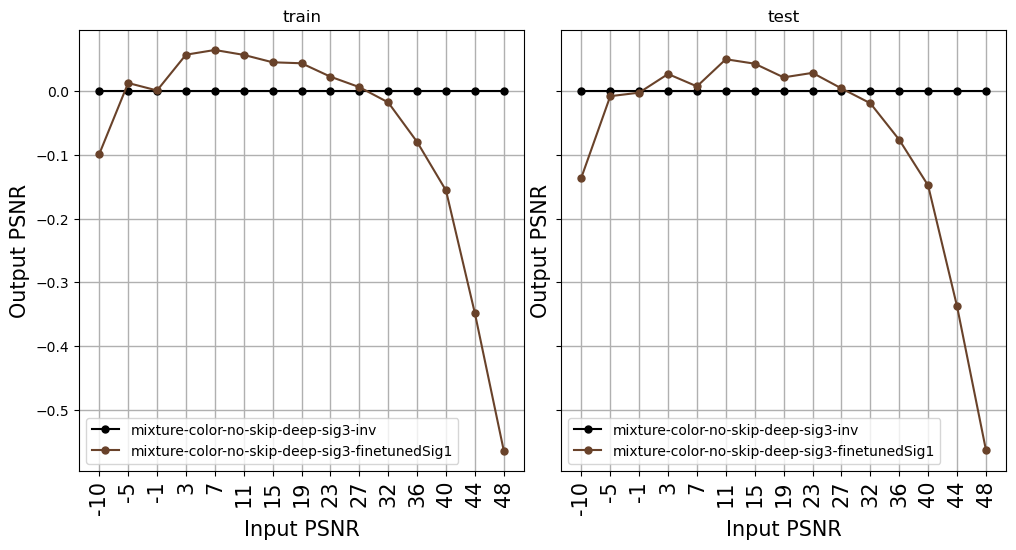

In [161]:
## plot 
f , axs = plt.subplots(1,2, figsize=(10,5), sharex = True, sharey=True)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[group].keys()]


for group in ['mixture-color-no-skip-deep-sig3-inv', 'mixture-color-no-skip-deep-sig3-finetunedSig1']:
    print(group)
    if 'color' in group.split('-'):
        axs[1].plot(x_axis, [psnr_test[group][key] - psnr_test['mixture-color-no-skip-deep-sig3-inv'][key] for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
        axs[0].plot(x_axis, [psnr_train[group][key] - psnr_train['mixture-color-no-skip-deep-sig3-inv'][key] for key in psnr_train[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
axs[0].set_title('train')
axs[1].set_title('test')

for i in range(2):
    axs[i].set_xticks(x_axis);
    axs[i].grid(  linewidth=1);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    # y_axis = np.linspace(10,60,5) 
    # axs.set_yticks(y_axis);
    
    # axs.set_yticklabels(np.round(y_axis).astype(int) , fontsize=15);    
    
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,  4)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
    axs[i].legend()      
    axs[i].set_xlabel('Input PSNR', fontsize = 15);
    axs[i].set_ylabel('Output PSNR', fontsize = 15);


mixture-color-no-skip-deep-sig3-sqrt-inv
mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs
mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1


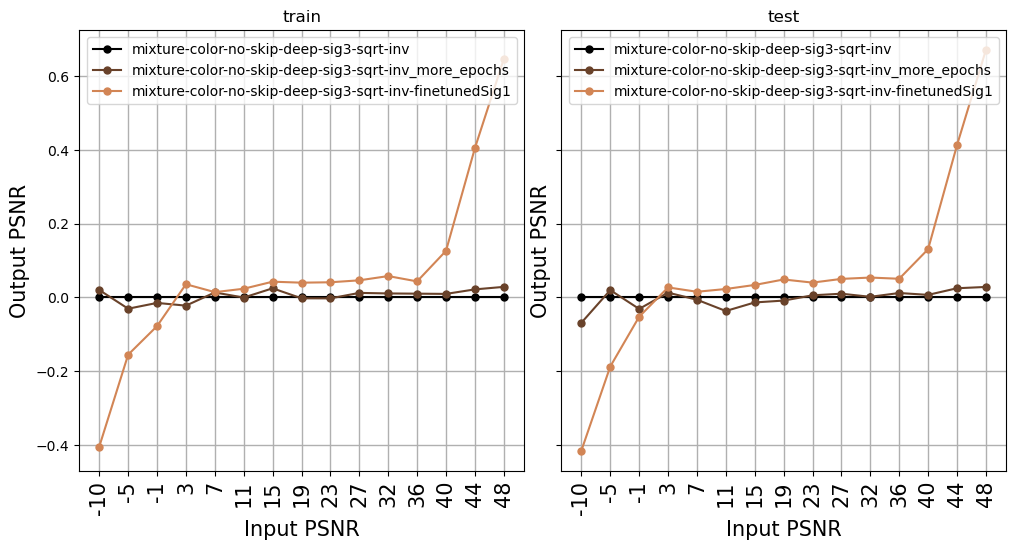

In [162]:
## plot 
f , axs = plt.subplots(1,2, figsize=(10,5), sharex = True, sharey=True)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[group].keys()]


for group in ['mixture-color-no-skip-deep-sig3-sqrt-inv', 'mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs', 'mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1']:
    print(group)
    if 'color' in group.split('-'):
        axs[1].plot(x_axis, [psnr_test[group][key] - psnr_test['mixture-color-no-skip-deep-sig3-sqrt-inv'][key] for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
        axs[0].plot(x_axis, [psnr_train[group][key] - psnr_train['mixture-color-no-skip-deep-sig3-sqrt-inv'][key] for key in psnr_train[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
axs[0].set_title('train')
axs[1].set_title('test')

for i in range(2):
    axs[i].set_xticks(x_axis);
    axs[i].grid(  linewidth=1);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    # y_axis = np.linspace(10,60,5) 
    # axs.set_yticks(y_axis);
    
    # axs.set_yticklabels(np.round(y_axis).astype(int) , fontsize=15);    
    
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,  4)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
    axs[i].legend()      
    axs[i].set_xlabel('Input PSNR', fontsize = 15);
    axs[i].set_ylabel('Output PSNR', fontsize = 15);


mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1
mixture-color-no-skip-deep-enc
mixture-color-no-skip-deep-sig3-sqrt-inv
mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs
mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1


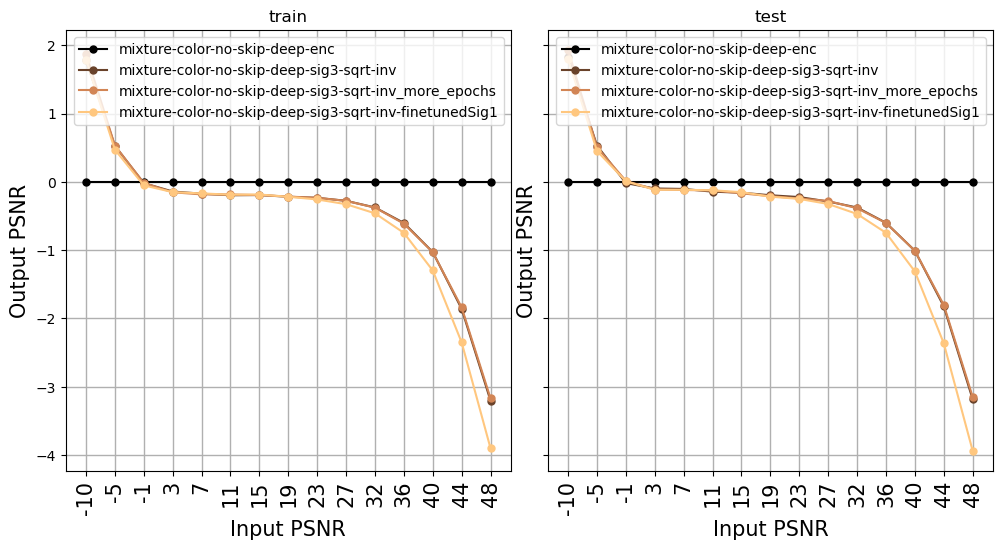

In [151]:
## plot 
f , axs = plt.subplots(1,2, figsize=(10,5), sharex = True, sharey=True)
plt.tight_layout()
print(group)
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[group].keys()]


for group in ['mixture-color-no-skip-deep-enc','mixture-color-no-skip-deep-sig3-sqrt-inv', 'mixture-color-no-skip-deep-sig3-sqrt-inv_more_epochs', 'mixture-color-no-skip-deep-sig3-sqrt-inv-finetunedSig1']:
    print(group)
    if 'color' in group.split('-'):
        axs[1].plot(x_axis, [psnr_test[group][key] - psnr_test['mixture-color-no-skip-deep-enc'][key] for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
        axs[0].plot(x_axis, [psnr_train[group][key] - psnr_train['mixture-color-no-skip-deep-enc'][key] for key in psnr_train[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)
axs[0].set_title('train')
axs[1].set_title('test')

for i in range(2):
    axs[i].set_xticks(x_axis);
    axs[i].grid(  linewidth=1);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    # y_axis = np.linspace(10,60,5) 
    # axs.set_yticks(y_axis);
    
    # axs.set_yticklabels(np.round(y_axis).astype(int) , fontsize=15);    
    
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,  4)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
    axs[i].legend()      
    axs[i].set_xlabel('Input PSNR', fontsize = 15);
    axs[i].set_ylabel('Output PSNR', fontsize = 15);


In [74]:
similarity_matrix = lambda data : data/data.norm(dim = 1, keepdim=True) @(data/data.norm(dim = 1, keepdim=True)).T
similarity_vactor = lambda data, v : (v/(v.norm(dim = 1, keepdim=True)+1e-6) @(data/(data.norm(dim = 1, keepdim=True) +1e-6 ) ).T).flatten()
similarity_matrix_2mats = lambda data1, data2 : data1/data1.norm(dim = 1, keepdim=True) @(data2/data2.norm(dim = 1, keepdim=True)).T

degree_matrix = lambda sim_mat : torch.diag(sim_mat.sum(dim = 1))

participation_ratio = lambda v :  (v.norm(1)**2)/v.norm(2)**2/len(v)
participation_ratio_dataset = lambda data :  (data.norm(1, dim = 1)**2)/data.norm(2,dim = 1)**2/data.shape[1]


(array([311.,  44.,  20.,  18.,  11.,   8.,   7.,   8.,  10.,  12.,   8.,
          2.,   6.,   5.,   5.,   5.,   5.,   1.,   1.,  25.]),
 array([0.002     , 0.05169085, 0.1013817 , 0.15107255, 0.2007634 ,
        0.25045425, 0.3001451 , 0.34983596, 0.3995268 , 0.44921765,
        0.4989085 , 0.54859936, 0.5982902 , 0.64798105, 0.6976719 ,
        0.74736273, 0.7970536 , 0.8467445 , 0.8964353 , 0.94612616,
        0.995817  ], dtype=float32),
 <BarContainer object of 20 artists>)

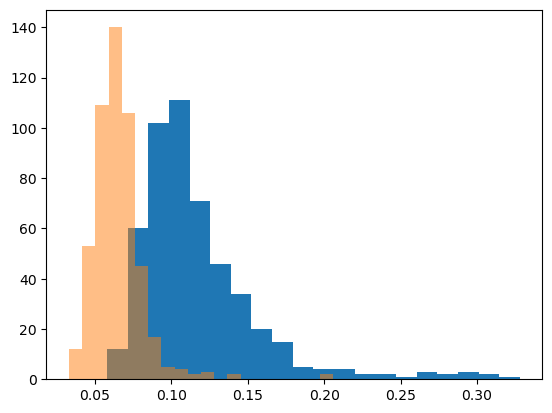

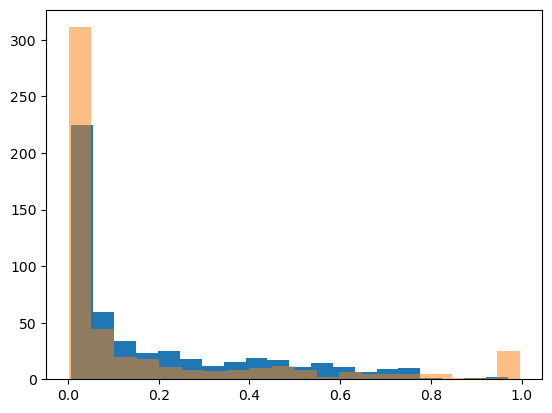

In [126]:
sig = 1
a_bars = get_activation_means_unconditional(denoisers['mixture-color-no-skip-deep-enc'] , train['inp'][0:500] + sig * torch.randn_like(train['inp'][0:500]) )

plt.hist(participation_ratio_dataset(a_bars[3] ).cpu(), bins = 20)

a_bars = get_activation_means_unconditional(denoisers[ 'mixture-color-no-skip-deep-sig3-sqrt-inv'] , train['inp'][0:500] + sig* torch.randn_like(train['inp'][0:500]) )

plt.hist(participation_ratio_dataset(a_bars[3] ).cpu(), alpha = .5, bins = 20)

plt.figure()
a_bars = get_activation_means_unconditional(denoisers['mixture-color-no-skip-deep-enc'] , train['inp'][0:500] + sig * torch.randn_like(train['inp'][0:500]) )

plt.hist(participation_ratio_dataset(a_bars[3].T ).cpu(), bins = 20)

a_bars = get_activation_means_unconditional(denoisers['mixture-color-no-skip-deep-sig3-sqrt-inv'] , train['inp'][0:500] + sig* torch.randn_like(train['inp'][0:500]) )

plt.hist(participation_ratio_dataset(a_bars[3].T ).cpu(), alpha = .5, bins = 20)


mixture-color
mixture-color-BF-BN
mixture-color-RF112
mixture-color-BF-BN-RF112
mixture-color-no-skip-deep-enc
mixture-color-no-skip-deep-enc-BF-BN


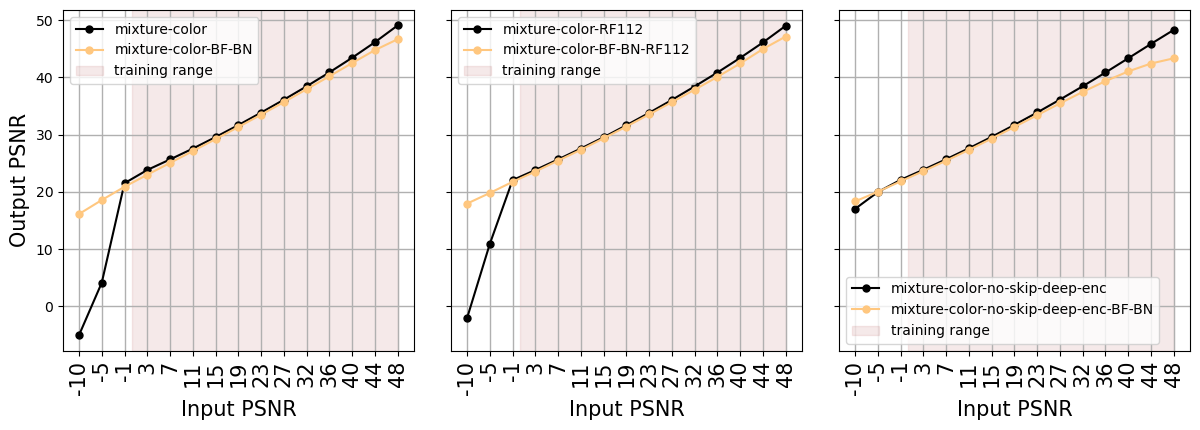

In [19]:
## Effect of Bias free 
## plot 
f , axs = plt.subplots(1,3, figsize=(12,4), sharex = True, sharey=True)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[group].keys()]

for group in ['mixture-color', 'mixture-color-BF-BN']: 
    print(group)
    if 'color' in group.split('-'):
        axs[0].plot(x_axis, [psnr_test[group][key]  for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)

for group in ['mixture-color-RF112', 'mixture-color-BF-BN-RF112']: 
    print(group)
    if 'color' in group.split('-'):
        axs[1].plot(x_axis, [psnr_test[group][key]  for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)

for group in ['mixture-color-no-skip-deep-enc', 'mixture-color-no-skip-deep-enc-BF-BN']: 
    print(group)
    if 'color' in group.split('-'):
        axs[2].plot(x_axis, [psnr_test[group][key]  for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)

for i in range(len(axs)):
    axs[i].axvspan(0,48 , color='brown', alpha=0.1, label='training range')
    axs[i].set_xticks(x_axis);
    axs[i].grid(  linewidth=1);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)    

    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1, 2)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
for i in range(len(axs)):

    axs[i].legend()      
    axs[i].set_xlabel('Input PSNR', fontsize = 15);

axs[0].set_ylabel('Output PSNR', fontsize = 15);


mixture-color
mixture-color-BF-BN
mixture-color-RF112
mixture-color-BF-BN-RF112
mixture-color-no-skip-deep-enc
mixture-color-no-skip-deep-enc-BF-BN


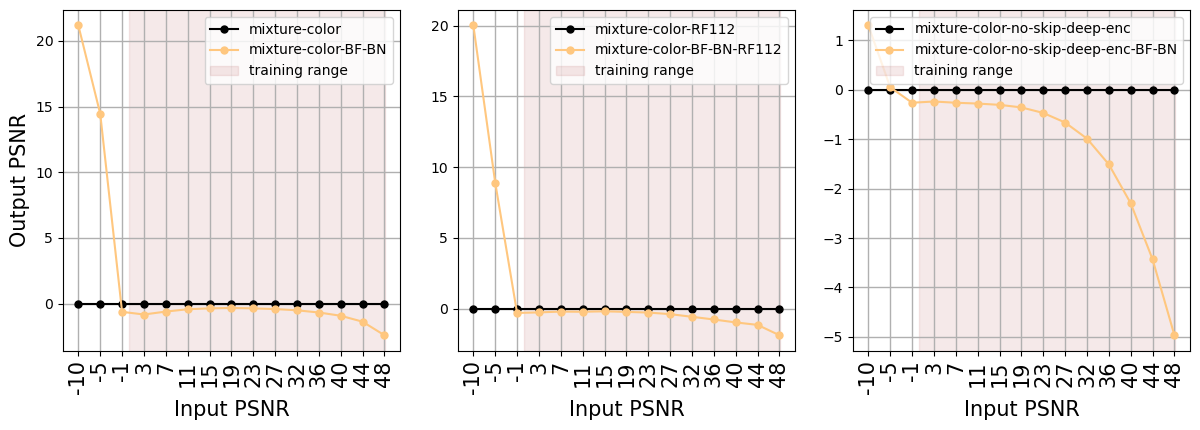

In [20]:
## Effect of Bias free 
## plot 
f , axs = plt.subplots(1,3, figsize=(12,4), sharex = True, sharey=False)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[group].keys()]

for group in ['mixture-color', 'mixture-color-BF-BN']: 
    print(group)
    if 'color' in group.split('-'):
        axs[0].plot(x_axis, [psnr_test[group][key] - psnr_test['mixture-color'][key] for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)

for group in ['mixture-color-RF112', 'mixture-color-BF-BN-RF112']: 
    print(group)
    if 'color' in group.split('-'):
        axs[1].plot(x_axis, [psnr_test[group][key] - psnr_test['mixture-color-RF112'][key] for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)

for group in ['mixture-color-no-skip-deep-enc', 'mixture-color-no-skip-deep-enc-BF-BN']: 
    print(group)
    if 'color' in group.split('-'):
        axs[2].plot(x_axis, [psnr_test[group][key]- psnr_test['mixture-color-no-skip-deep-enc'][key]  for key in psnr_test[group].keys()], 
                    marker = '.',markersize = 10, label = group , alpha = 1)

for i in range(len(axs)):
    axs[i].axvspan(0,48 , color='brown', alpha=0.1, label='training range')
    axs[i].set_xticks(x_axis);
    axs[i].grid(  linewidth=1);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
   
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1, 2)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
for i in range(len(axs)):

    axs[i].legend()      
    axs[i].set_xlabel('Input PSNR', fontsize = 15);

axs[0].set_ylabel('Output PSNR', fontsize = 15);


Text(0.5, 1.0, 'test')

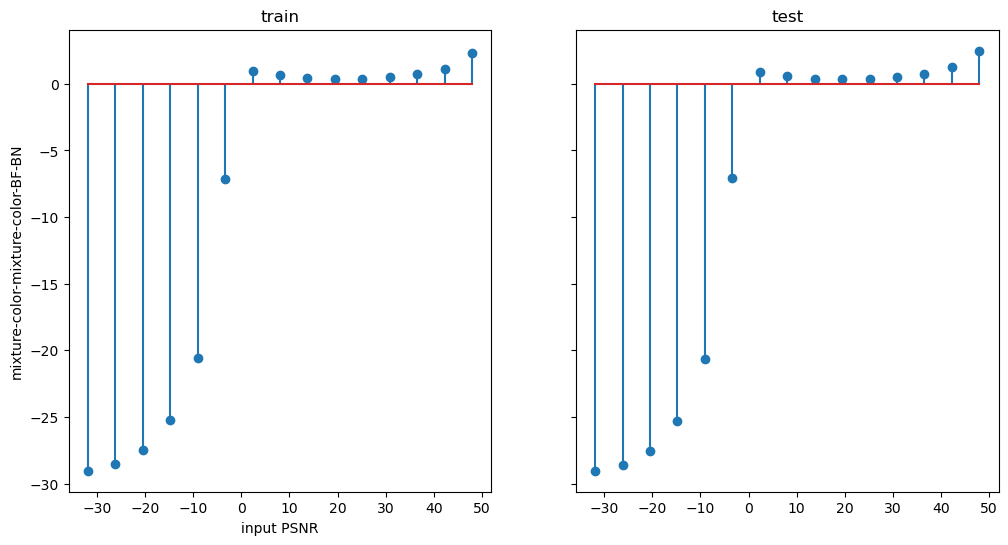

In [66]:
denoiser1 = 'mixture-color'
denoiser2 = 'mixture-color-BF-BN'
f , axs = plt.subplots(1,2, figsize=(12,6), sharex = True, sharey=True)

axs[0].stem(x_axis,[psnr_train[denoiser1][key] - psnr_train[denoiser2][key] for key in psnr_train[group].keys()])
axs[1].stem(x_axis,[psnr_test[denoiser1][key] - psnr_test[denoiser2][key] for key in psnr_train[group].keys()])
axs[0].set_xlabel('input PSNR')
axs[0].set_ylabel(denoiser1+ '-'+ denoiser2)
axs[0].set_title('train')
axs[1].set_title('test')

Text(0.5, 1.0, 'test')

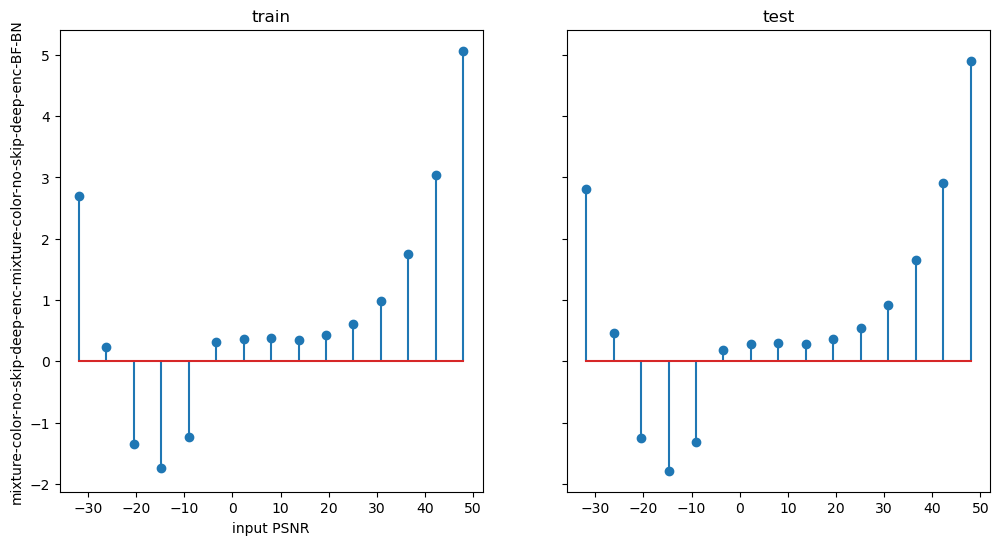

In [65]:
denoiser1 =  'mixture-color-no-skip-deep-enc'
denoiser2 = 'mixture-color-no-skip-deep-enc-BF-BN'
f , axs = plt.subplots(1,2, figsize=(12,6), sharex = True, sharey=True)

axs[0].stem(x_axis,[psnr_train[denoiser1][key] - psnr_train[denoiser2][key] for key in psnr_train[group].keys()])
axs[1].stem(x_axis,[psnr_test[denoiser1][key] - psnr_test[denoiser2][key] for key in psnr_train[group].keys()])
axs[0].set_xlabel('input PSNR')
axs[0].set_ylabel(denoiser1+ '-'+ denoiser2)
axs[0].set_title('train')
axs[1].set_title('test')

### compare architectuers 

mixture-gray-2223444
mixture-gray-3333333
mixture-gray-4443222
mixture-gray-4442444
mixture-gray-2223444-256ch


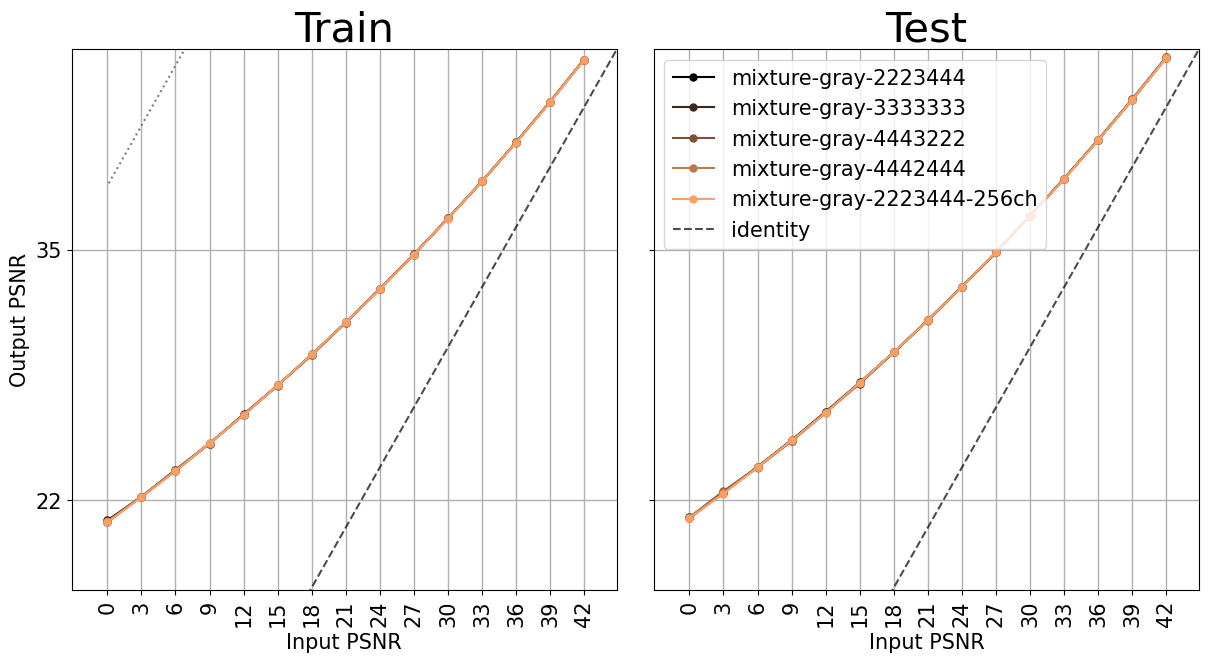

In [26]:
## plot 


f , axs = plt.subplots(1,2, figsize=(12,6), sharex = True, sharey=True)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_train[group].keys()]

for group in groups: 
    print(group)
    ## train 
    axs[0].plot(x_axis, [psnr_train[group][key] for key in psnr_train[group].keys()], 
                marker = '.',markersize = 10, label = group , alpha = 1)
    
    ## test 
    axs[1].plot(x_axis, [psnr_test[group][key] for key in psnr_test[group].keys()], 
                marker = '.',markersize = 10,label =  group , alpha = 1)
for i in range(2):
    axs[i].set_xticks(x_axis);
    axs[i].grid(  linewidth=1);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    axs[i].set_xlim(-3, 45)
    
    y_axis = np.linspace(10,60,5) 
    axs[i].set_yticks(y_axis);
    
    axs[i].set_yticklabels(np.round(y_axis).astype(int) , fontsize=15);
    axs[i].set_ylim(18, 45)

    # axs[0].plot(x_axis, [ -10*np.log10( (std/255)**2  ) for std in sig_range/40 ],linestyle = 'dotted', label = 'expected from 1d manifold(N=1)')
    

    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1, len(groups)+1)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
axs[0].plot(x_axis, [ -10*np.log10( (std/255)**2  ) for std in sig_range/K ],linestyle = 'dotted', label = 
            'expected from 1d manifold(N=1)', color='gray')
axs[0].plot( [0,65],[0,65] ,'k--', alpha = .7, label = 'identity');
axs[1].plot( [0,65],[0,65] ,'k--', alpha = .7, label = 'identity');

    # axs[i].axvspan(0, 65, alpha=0.2);
axs[1].legend(fontsize = 15);
axs[0].set_title('Train', fontsize = 30)
axs[1].set_title('Test', fontsize = 30)
axs[0].set_xlabel('Input PSNR', fontsize = 15)
axs[0].set_ylabel('Output PSNR', fontsize = 15);
axs[1].set_xlabel('Input PSNR', fontsize = 15);


In [27]:
groups

psnr_train.keys()

dict_keys(['mixture-gray-2223444', 'mixture-gray-3333333', 'mixture-gray-4443222', 'mixture-gray-4442444', 'mixture-gray-2223444-256ch'])

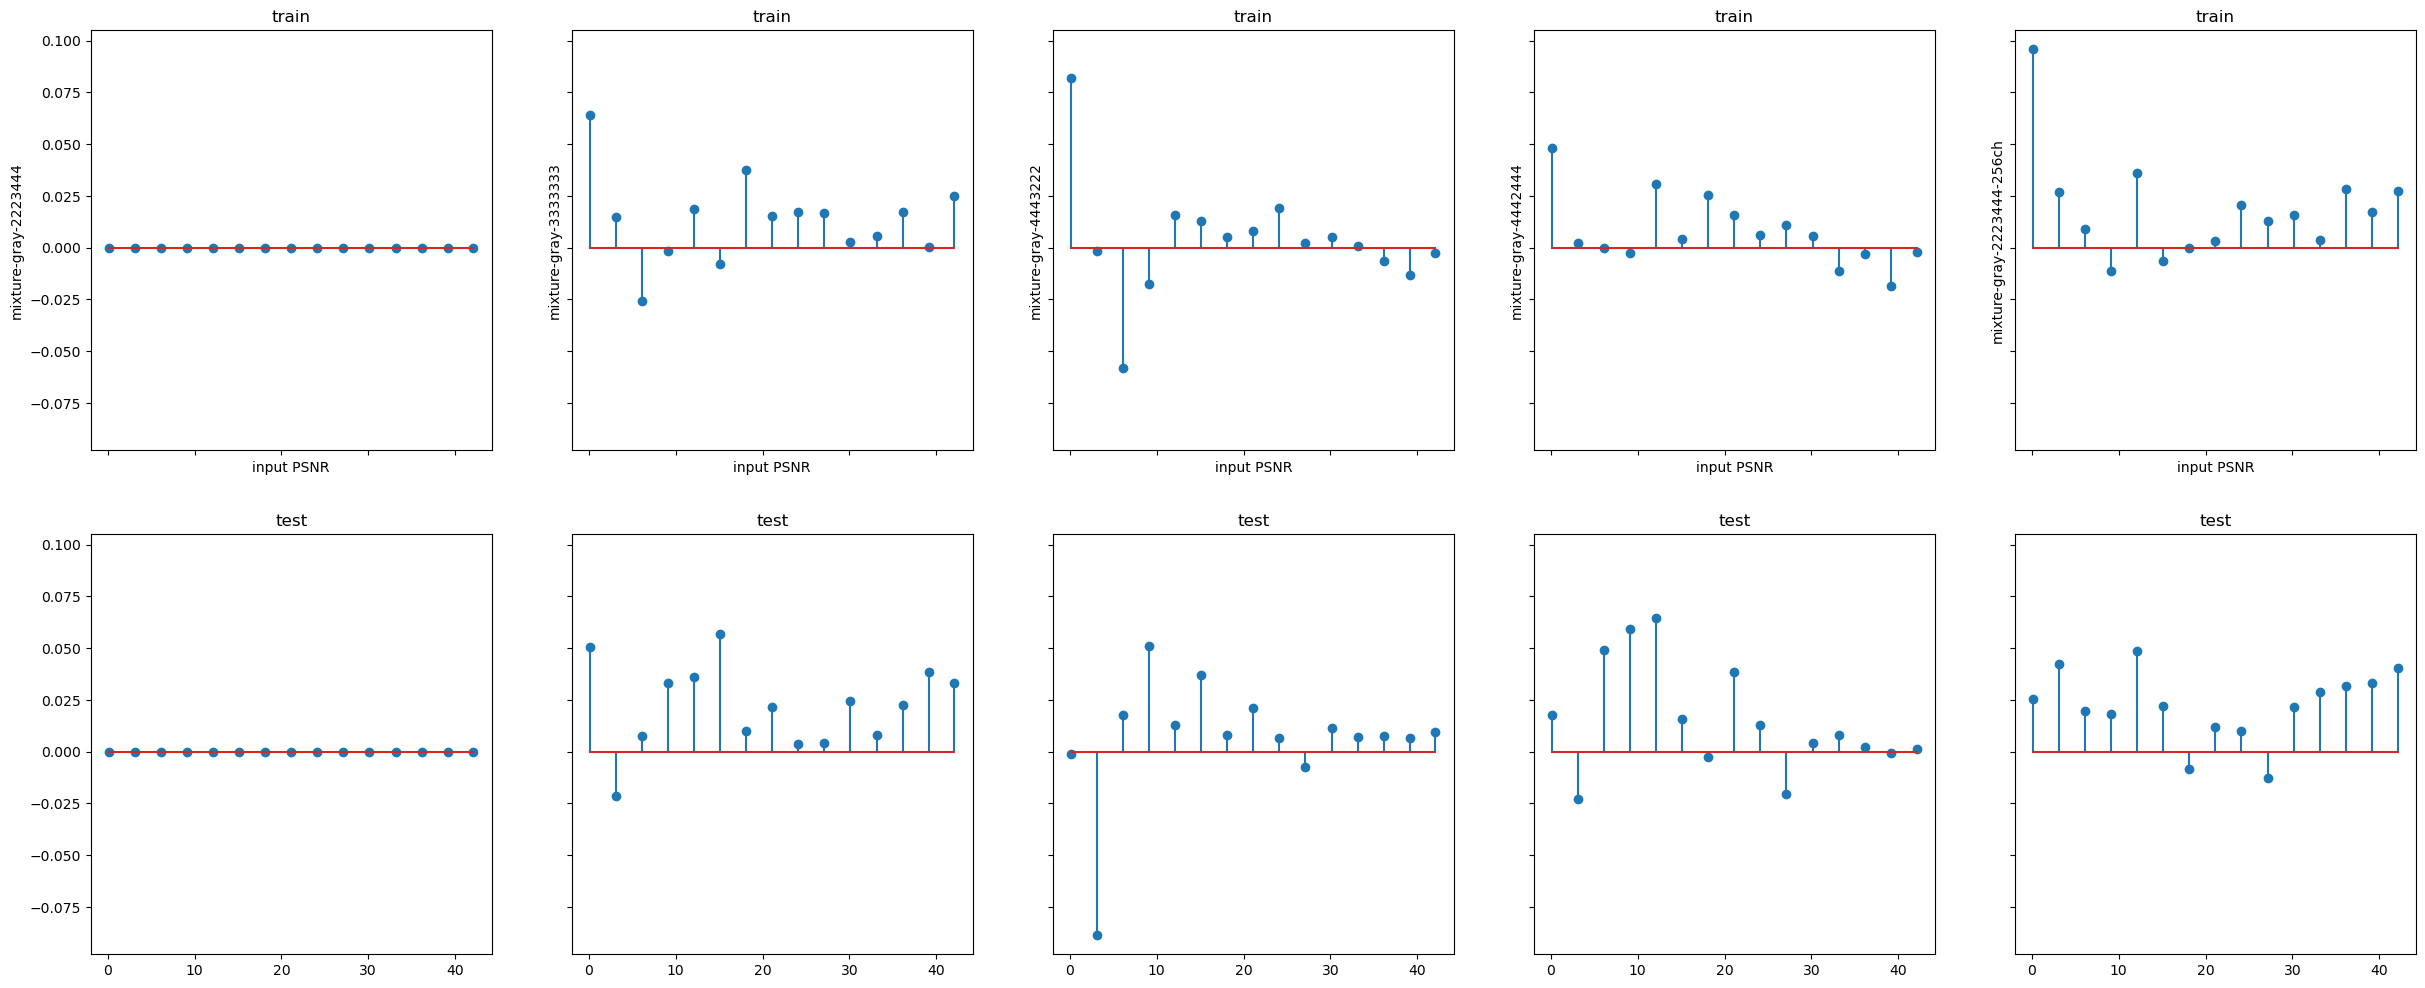

In [28]:
denoiser1 =  'mixture-gray-2223444'
f , axs = plt.subplots(2,len(groups) , figsize=(6* len(groups),12), sharex = True, sharey=True)

for i,group in zip(range(len(group)),groups):
    axs[0,i].stem(x_axis,[psnr_train[denoiser1][key] - psnr_train[group][key] for key in psnr_train[group].keys()])
    axs[1,i].stem(x_axis,[psnr_test[denoiser1][key] - psnr_test[group][key] for key in psnr_train[group].keys()])
    axs[0,i].set_xlabel('input PSNR')
    axs[0,i].set_ylabel(group)
    axs[0,i].set_title('train')
    axs[1,i].set_title('test')